# AIN311 COURSE PROJECT


## Feature  Desription :
url :https://data.scorenetwork.org/hockey/nhl-shots.html

| Variable                | Description                                                                                                     |
|-------------------------|-----------------------------------------------------------------------------------------------------------------|
| `game_id`               | Unique integer identifier for game shot took place in                                                          |
| `description`           | String detailed description of shot event                                                                      |
| `shot_outcome`          | String denoting the outcome of the shot, either BLOCKED_SHOT (meaning blocked by a non-goalie), GOAL, MISSED_SHOT (shot that missed the net), or SHOT (shot on net that was saved by a goalie) |
| `period`                | Integer value of the game period                                                                               |
| `period_seconds_remaining` | Numeric value of the seconds remaining in the period                                                       |
| `game_seconds_remaining`   | Numeric value of the seconds remaining in the game; negative for overtime periods                         |
| `home_score`            | Integer value of the home team score after the event                                                           |
| `away_score`            | Integer value of the away team score after the event                                                           |
| `home_name`             | String name of the home team                                                                                   |
| `away_name`             | String name of the away team                                                                                   |
| `event_team`            | String defining the team taking the shot                                                                      |
| `event_goalie_name`     | String name of goalie (if in net)                                                                             |
| `empty_net`             | Boolean indicating if the shot was during an empty net situation, TRUE if so but FALSE or NA if not           |
| `event_player_1_name`   | String name of the primary event player                                                                       |
| `event_player_1_type`   | String indicator for the role of event_player_1 (typically the shooter)                                       |
| `event_player_2_name`   | String name of the secondary event player                                                                     |
| `event_player_2_type`   | String indicator for the role of event_player_2 (blocker, assist, or goalie)                                  |
| `strength_code`         | String indicator for game strength: EV (Even), SH (Shorthanded), or PP (Power Play)                           |
| `x_fixed`               | Numeric transformed x-coordinate of event in feet, where the home team always shoots to the right, away team to the left |
| `y_fixed`               | Numeric transformed y-coordinate of event in feet, where the home team always shoots to the right, away team to the left |
| `shot_distance`         | Numeric distance (in feet) to center of net for unblocked shot events                                         |
| `shot_angle`            | Numeric angle (in degrees) to center of net for unblocked shot events                                          |


In [1]:
#import  libraries
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,learning_curve




### Data Summary


In [2]:
#load data and display
df = pd.read_csv('shots.csv')
df.head(5)

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,2021020001,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,1137,3537,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Steven.Stamkos,Shooter,Tristan.Jarry,Goalie,EV,61.0,-32.0,42.5,48.8
1,2021020001,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,1115,3515,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Zach.Bogosian,Shooter,Brock.McGinn,Blocker,EV,60.0,-17.0,NaN,NaN
2,2021020001,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,1096,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Brock.McGinn,Shooter,Andrei.Vasilevskiy,Goalie,EV,-65.0,19.0,30.6,38.4
3,2021020001,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,1079,3479,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Jan.Rutta,Shooter,Tristan.Jarry,Goalie,EV,-8.0,-27.0,100.7,15.6
4,2021020001,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,1033,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Danton.Heinen,Shooter,Andrei.Vasilevskiy,Goalie,EV,-60.0,-4.0,29.3,7.9


In [3]:
# summary about entries and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160573 entries, 0 to 160572
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   160573 non-null  int64  
 1   description               160573 non-null  object 
 2   shot_outcome              160573 non-null  object 
 3   period                    160573 non-null  int64  
 4   period_seconds_remaining  160573 non-null  int64  
 5   game_seconds_remaining    160573 non-null  int64  
 6   home_score                160573 non-null  int64  
 7   away_score                160573 non-null  int64  
 8   home_name                 160573 non-null  object 
 9   away_name                 160573 non-null  object 
 10  event_team                160573 non-null  object 
 11  event_goalie_name         89064 non-null   object 
 12  empty_net                 8712 non-null    object 
 13  event_player_1_name       160573 non-null  o

In [4]:
#distinguish between categorical and numeric columns
numerical_features =['period','period_seconds_remaining','game_seconds_remaining','home_score','away_score','x_fixed','y_fixed','shot_distance','shot_angle','game_id']
categorical_features = df.columns.difference(numerical_features).tolist()

In [5]:
df[numerical_features].loc[:,:].describe(include='all').style.background_gradient(cmap='Greys')

,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,x_fixed,y_fixed,shot_distance,shot_angle,game_id
count,160573.000000,160573.000000,160573.000000,160573.000000,160573.000000,160560.000000,160560.000000,122349.000000,122349.000000,160573.000000
mean,2.035106,587.206268,1767.206018,1.525312,1.384660,2.059897,0.108402,35.198477,30.149606,2021021322.001358
std,0.860840,348.952383,1055.099727,1.531118,1.403652,64.821917,17.164142,24.087589,21.148277,2455.421940
min,1.000000,0.000000,-1193.000000,0.000000,0.000000,-99.000000,-42.000000,1.000000,0.000000,2021020001.000000
25%,1.000000,281.000000,868.000000,0.000000,0.000000,-65.000000,-11.000000,17.100000,13.400000,2021020356.000000
50%,2.000000,589.000000,1779.000000,1.000000,1.000000,31.000000,0.000000,32.000000,28.000000,2021020710.000000
75%,3.000000,891.000000,2674.000000,2.000000,2.000000,67.000000,11.000000,48.500000,42.300000,2021021058.000000
max,6.000000,1198.000000,3597.000000,11.000000,10.000000,99.000000,42.000000,189.200000,173.700000,2021030416.000000


In [6]:
df[categorical_features].loc[:,:].describe().style.background_gradient(cmap='Greys')

,away_name,description,empty_net,event_goalie_name,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,event_team,home_name,shot_outcome,strength_code
count,160573,160573,8712,89064,160573,160573,160199,160199,160573,160573,160573,160267
unique,32,111872,2,120,1004,2,1070,4,32,32,4,3
top,Tampa Bay Lightning,Evan Rodrigues Wrist Shot saved by Igor Shesterkin,False,Andrei.Vasilevskiy,Nathan.MacKinnon,Shooter,Andrei.Vasilevskiy,Goalie,Colorado Avalanche,Colorado Avalanche,SHOT,EV
freq,6094,30,8195,2633,700,151637,3434,81326,6619,6243,80648,128438


In [7]:
# Check for empty rows
empty_rows = df.isna().all(axis=1)
df[empty_rows]


,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle


No empty rows detected.

In [8]:
#check duplicates
df[df.duplicated]

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
139212,2021021223,Ben Chiarot Backhand saved by Ilya Sorokin,SHOT,2,742,1942,1,0,New York Islanders,Florida Panthers,...,NaN,Ben.Chiarot,Shooter,Ilya.Sorokin,Goalie,EV,-85.0,-6.0,7.2,56.3


In [9]:
#remove duplicates
df.drop_duplicates(inplace=True) 

 `shot_outcome`          | String denoting the outcome of the shot, either BLOCKED_SHOT (meaning blocked by a non-goalie), GOAL, MISSED_SHOT (shot that missed the net), or SHOT (shot on net that was saved by a goalie) |


In [10]:
df['shot_outcome'] = df['shot_outcome'].replace('SHOT', 'SAVED_SHOT')


In [11]:
#check missing values
df.isnull().sum()

game_id                          0
description                      0
shot_outcome                     0
period                           0
period_seconds_remaining         0
game_seconds_remaining           0
home_score                       0
away_score                       0
home_name                        0
away_name                        0
event_team                       0
event_goalie_name            71509
empty_net                   151860
event_player_1_name              0
event_player_1_type              0
event_player_2_name            374
event_player_2_type            374
strength_code                  306
x_fixed                         13
y_fixed                         13
shot_distance                38224
shot_angle                   38224
dtype: int64

I will determine the predictors by corolatiron analysis and feature ımportance  then handling the missing values ın the selected features.

## Corolation Analysis

Correlation analysis is a statistical method used to measure the strength and direction of the relationship between two variables. In the context of feature engineering, it helps identify how closely each feature is associated with the target variable. The correlation coefficient, which ranges from -1 to 1, quantifies this relationship. A value close to 1 indicates a strong positive correlation, meaning that as the feature value increases, the target variable also tends to increase. Conversely, a value close to -1 indicates a strong negative correlation, where an increase in the feature value is associated with a decrease in the target variable. A correlation coefficient near 0 suggests little to no linear relationship between the feature and the target.

In feature selection, correlation analysis is valuable for identifying relevant predictors. Features with high correlation to the target variable are likely to be useful for the model, while those with very low or no correlation may be irrelevant. Additionally, correlation analysis can reveal multicollinearity among features—situations where two or more features are highly correlated with each other. Multicollinearity can lead to redundancy and negatively impact the model's performance, so such features may need to be removed or transformed.

To start, I will calculate the correlation between the target variable and other features to identify significant relationships. Following this, I will create a correlation matrix to analyze the relationships between all features in the dataset. Finally, I will visualize the results using a heatmap, which will help highlight both the strength of the correlations and any potential multicollinearity among the features.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160572 entries, 0 to 160572
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   160572 non-null  int64  
 1   description               160572 non-null  object 
 2   shot_outcome              160572 non-null  object 
 3   period                    160572 non-null  int64  
 4   period_seconds_remaining  160572 non-null  int64  
 5   game_seconds_remaining    160572 non-null  int64  
 6   home_score                160572 non-null  int64  
 7   away_score                160572 non-null  int64  
 8   home_name                 160572 non-null  object 
 9   away_name                 160572 non-null  object 
 10  event_team                160572 non-null  object 
 11  event_goalie_name         89063 non-null   object 
 12  empty_net                 8712 non-null    object 
 13  event_player_1_name       160572 non-null  object

There are categorical features , to use corrolation matrix I will encode them. 

In [13]:
encoder = LabelEncoder()
df_encoded =df.copy()
for i in categorical_features:
    df_encoded[i]=df[[i]].apply(encoder.fit_transform)
df_encoded.head()

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,2021020001,97782,3,1,1137,3537,0,0,26,22,...,2,890,1,998,2,0,61.0,-32.0,42.5,48.8
1,2021020001,110389,0,1,1115,3515,0,0,26,22,...,2,992,1,157,1,0,60.0,-17.0,NaN,NaN
2,2021020001,17415,3,1,1096,3496,0,0,26,22,...,2,150,1,62,2,0,-65.0,19.0,30.6,38.4
3,2021020001,45752,3,1,1079,3479,0,0,26,22,...,2,415,1,998,2,0,-8.0,-27.0,100.7,15.6
4,2021020001,26755,3,1,1033,3433,0,0,26,22,...,2,242,1,62,2,0,-60.0,-4.0,29.3,7.9


In [14]:
# Correlation with the target variable

corr_matrix = df_encoded.corr()
target_corr = corr_matrix['shot_outcome'].sort_values(ascending=False)
print(target_corr)


shot_outcome                1.000000
event_player_2_type         0.584814
event_player_1_type         0.191774
empty_net                   0.187749
shot_distance               0.111750
shot_angle                  0.043855
period_seconds_remaining    0.011461
event_player_1_name         0.006183
description                 0.005391
strength_code               0.004701
game_seconds_remaining      0.003742
period                      0.003706
event_team                 -0.000320
away_name                  -0.004255
x_fixed                    -0.004370
y_fixed                    -0.005670
game_id                    -0.009897
home_name                  -0.010296
home_score                 -0.014146
away_score                 -0.017599
event_player_2_name        -0.060182
event_goalie_name          -0.581755
Name: shot_outcome, dtype: float64


Over 10% corrolated columns are: shot distance ,empty_net , event_player_2_type ,event_player_1_type.

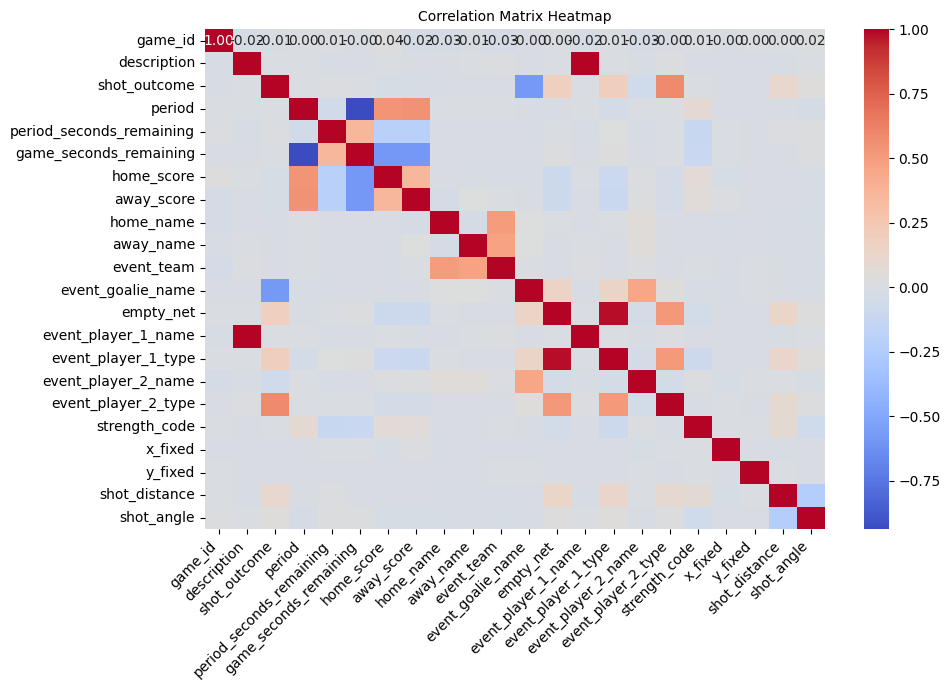

In [15]:

# Plot the heatmap
plt.figure(figsize=(10, 7))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add title for better readability
plt.title("Correlation Matrix Heatmap", fontsize=10)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal
plt.tight_layout()  # Avoid clipping labels
plt.show()




### Feature Importances

Feature importance is a technique used to quantify how influential each input feature is in predicting the target variable in a machine learning model. It helps determine which features contribute most to the model's performance or accuracy.It can be calculated in various ways depending on the model type and context. For tree-based models, it is often measured by the reduction in impurity (e.g., Gini impurity or entropy) achieved when a feature is used to split the data. Permutation importance, on the other hand, assesses importance by shuffling feature values and observing the resulting change in model performance. 
In feature engineering,it helps with feature selection by identifying and retaining only the most influential features, thereby reducing dimensionality and enhancing model efficiency. At the same time, it allows practitioners to eliminate irrelevant or redundant features that might introduce noise.Additionally, it can help detect overfitting if certain features, such as ID columns, appear overly influential, indicating potential data leakage. 
Since my dataset contains 160,000 entries and 22 features, I will use feature importance from a Random Forest model alongside the results of correlation analysis. Afterward, I will evaluate both the correlation analysis and feature importance results to identify the most effective predictors.

In [16]:
'''X = df_encoded.drop(columns=['shot_outcome'])  # Features
y = df_encoded['shot_outcome']                # Target

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importance scores
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Visualize feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


# Compute permutation importance
perm_importance = permutation_importance(rf, X, y, scoring='accuracy')

# Convert to DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_importance_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='orange')
plt.xlabel('Permutation Importance Score')
plt.ylabel('Features')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()'''

"X = df_encoded.drop(columns=['shot_outcome'])  # Features\ny = df_encoded['shot_outcome']                # Target\n\n# Train a Random Forest model\nrf = RandomForestClassifier(random_state=42)\nrf.fit(X, y)\n\n# Get feature importance scores\nfeature_importances = pd.DataFrame({\n    'Feature': X.columns,\n    'Importance': rf.feature_importances_\n}).sort_values(by='Importance', ascending=False)\n\nprint(feature_importances)\n\n# Visualize feature importance\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(10, 6))\nplt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')\nplt.xlabel('Feature Importance Score')\nplt.ylabel('Features')\nplt.title('Feature Importance')\nplt.gca().invert_yaxis()  # Highest importance at the top\nplt.show()\n\n\n# Compute permutation importance\nperm_importance = permutation_importance(rf, X, y, scoring='accuracy')\n\n# Convert to DataFrame\nperm_importance_df = pd.DataFrame({\n    'Feature': X.columns,\n    'Impor

### Remove no related columns 

I will combine the results of both corrolation analysis and feature importances.Less data may affect bad , therefore I try to use more data as far as feasible. In addition labelencoder filled the missing values , I will get the ımportant feature from original dataset (which is df) 

In [17]:
important_features = ['event_player_2_type','event_goalie_name','shot_distance'  ,'shot_angle' ,'event_player_1_type','empty_net','shot_outcome' ] # ımportant features + target  
predictors = df[important_features]
predictors.head()

,event_player_2_type,event_goalie_name,shot_distance,shot_angle,event_player_1_type,empty_net,shot_outcome
0,Goalie,Tristan.Jarry,42.5,48.8,Shooter,NaN,SAVED_SHOT
1,Blocker,NaN,NaN,NaN,Shooter,NaN,BLOCKED_SHOT
2,Goalie,Andrei.Vasilevskiy,30.6,38.4,Shooter,NaN,SAVED_SHOT
3,Goalie,Tristan.Jarry,100.7,15.6,Shooter,NaN,SAVED_SHOT
4,Goalie,Andrei.Vasilevskiy,29.3,7.9,Shooter,NaN,SAVED_SHOT


## Handling missing values on the ımportant features

In [18]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160572 entries, 0 to 160572
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_player_2_type  160198 non-null  object 
 1   event_goalie_name    89063 non-null   object 
 2   shot_distance        122348 non-null  float64
 3   shot_angle           122348 non-null  float64
 4   event_player_1_type  160572 non-null  object 
 5   empty_net            8712 non-null    object 
 6   shot_outcome         160572 non-null  object 
dtypes: float64(2), object(5)
memory usage: 9.8+ MB


In [19]:
predictors.isnull().sum()

event_player_2_type       374
event_goalie_name       71509
shot_distance           38224
shot_angle              38224
event_player_1_type         0
empty_net              151860
shot_outcome                0
dtype: int64

In [20]:
predictors.loc[:,:].describe(include='all').style.background_gradient(cmap='Greys')

,event_player_2_type,event_goalie_name,shot_distance,shot_angle,event_player_1_type,empty_net,shot_outcome
count,160198,89063,122348.000000,122348.000000,160572,8712,160572
unique,4,120,nan,nan,2,2,4
top,Goalie,Andrei.Vasilevskiy,nan,nan,Shooter,False,SAVED_SHOT
freq,81325,2633,nan,nan,151636,8195,80647
mean,nan,nan,35.198706,30.149393,nan,nan,nan
std,nan,nan,24.087554,21.148231,nan,nan,nan
min,nan,nan,1.000000,0.000000,nan,nan,nan
25%,nan,nan,17.100000,13.400000,nan,nan,nan
50%,nan,nan,32.000000,28.000000,nan,nan,nan
75%,nan,nan,48.500000,42.300000,nan,nan,nan


`empty_net`Boolean indicating if the shot was during an empty net situation, TRUE if so but FALSE or NA if not. Therefore missing values can be filled by `False`.           


In [21]:
# Fill NaN values with boolean False, then infer objects to avoid warnings
predictors['empty_net'] = predictors['empty_net'].fillna(False)
predictors['empty_net'] = predictors['empty_net'].infer_objects(copy=False)
predictors['empty_net'] = predictors['empty_net'].astype(bool)

C:\Users\NURŞAH SATILMIŞ\AppData\Local\Temp\ipykernel_30796\3518865989.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictors['empty_net'] = predictors['empty_net'].fillna(False)
C:\Users\NURŞAH SATILMIŞ\AppData\Local\Temp\ipykernel_30796\3518865989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors['empty_net'] = predictors['empty_net'].fillna(False)
C:\Users\NURŞAH SATILMIŞ\AppData\Local\Temp\ipykernel_30796\3518865989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [22]:
predictors['empty_net'].value_counts()

empty_net
False    160055
True        517
Name: count, dtype: int64

In [23]:
predictors.isnull().sum()

event_player_2_type      374
event_goalie_name      71509
shot_distance          38224
shot_angle             38224
event_player_1_type        0
empty_net                  0
shot_outcome               0
dtype: int64

`event_goalie_name`    : String name of goalie/ goalkeeper (if in net) 
it related to empthy_net features , we should ınvestigate both

In [24]:
# Look at the values
predictors['event_goalie_name'].isnull().sum()

71509

In [25]:
# filter the part of 'event_goalie name' is missing
temp = predictors[predictors['event_goalie_name'].isnull()] 
temp['empty_net'].value_counts()

empty_net
False    70992
True       517
Name: count, dtype: int64

Out of 71,526 instances, 517 missing `event_goalie_name` values indicate situations where there was actually nobody in the net. We can impute these values with 'nobody' to signify an empty net scenario. However, the reason for the remaining missing values is unknown.

In [26]:
# Fill missing 'event_goalie_name' values with 'nobody' where 'empty_net' is True 
predictors.loc[(predictors['event_goalie_name'].isnull()) & (predictors['empty_net'] == True), 'event_goalie_name'] = 'nobody'


In [27]:
predictors.isnull().sum()

event_player_2_type      374
event_goalie_name      70992
shot_distance          38224
shot_angle             38224
event_player_1_type        0
empty_net                  0
shot_outcome               0
dtype: int64

517 of missing values was handled. by "nobody" label which indicates nobody save net.

In [28]:
predictors.loc[:, 'event_goalie_name'] = predictors['event_goalie_name'].fillna('Unknown')


In [29]:
predictors.isnull().sum()

event_player_2_type      374
event_goalie_name          0
shot_distance          38224
shot_angle             38224
event_player_1_type        0
empty_net                  0
shot_outcome               0
dtype: int64

Other missing values filled by "unknown" , it indicates that we do not know the golie name or whether was there a golie or not .

`event_player_2_type` : String indicator for the role of event_player_2 (blocker, assist, or goalie)

In [30]:
predictors['event_player_2_type'].value_counts()

event_player_2_type
Goalie     81325
Blocker    38224
Unknown    32485
Assist      8164
Name: count, dtype: int64

In [31]:
predictors.loc[:,'event_player_2_type'] = predictors['event_player_2_type'].fillna("")


In [32]:
predictors.isnull().sum()

event_player_2_type        0
event_goalie_name          0
shot_distance          38224
shot_angle             38224
event_player_1_type        0
empty_net                  0
shot_outcome               0
dtype: int64

`shot_distance`

In [33]:
predictors[predictors['shot_distance'].isnull()]


,event_player_2_type,event_goalie_name,shot_distance,shot_angle,event_player_1_type,empty_net,shot_outcome
1,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
6,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
7,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
11,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
14,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
...,...,...,...,...,...,...,...
160565,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
160567,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
160568,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT
160569,Blocker,Unknown,NaN,NaN,Shooter,False,BLOCKED_SHOT


In [34]:
predictors[predictors['shot_distance'].isna()].isnull().sum()

event_player_2_type        0
event_goalie_name          0
shot_distance          38224
shot_angle             38224
event_player_1_type        0
empty_net                  0
shot_outcome               0
dtype: int64

when shot_distance is null ,shot_angle also is nan.We can handle missing values of both of them.

<Axes: >

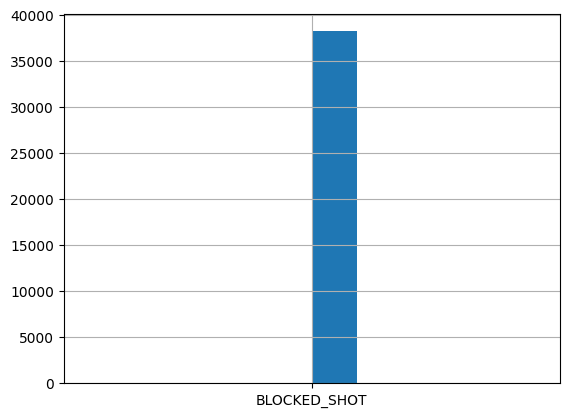

In [35]:
#what is the target when shot distane is missing 
predictors[predictors['shot_distance'].isna()]['shot_outcome'].hist()

When Shot distance is missing , shot is blocked. 

In [36]:
#check blocked shot 
predictors[predictors['shot_outcome']== 'BLOCKED_SHOT'].isnull().sum()

event_player_2_type        0
event_goalie_name          0
shot_distance          38224
shot_angle             38224
event_player_1_type        0
empty_net                  0
shot_outcome               0
dtype: int64

If shot is blocked , there was  no distance calculated.There are no misleading or unknown stuation. We can replace the null values with '-1'. Since the shot distance starts from zero, this substitution should not cause any issues.

In [37]:
predictors.loc[:,'shot_distance']= predictors['shot_distance'].fillna(-1)
predictors.loc[:,'shot_angle']= predictors['shot_angle'].fillna(-1)

predictors.isnull().sum()

event_player_2_type    0
event_goalie_name      0
shot_distance          0
shot_angle             0
event_player_1_type    0
empty_net              0
shot_outcome           0
dtype: int64

## Data Visualization

In [38]:
# summarize the datatype
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160572 entries, 0 to 160572
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_player_2_type  160572 non-null  object 
 1   event_goalie_name    160572 non-null  object 
 2   shot_distance        160572 non-null  float64
 3   shot_angle           160572 non-null  float64
 4   event_player_1_type  160572 non-null  object 
 5   empty_net            160572 non-null  bool   
 6   shot_outcome         160572 non-null  object 
dtypes: bool(1), float64(2), object(4)
memory usage: 8.7+ MB


In [39]:
pred_numeric=predictors.select_dtypes(include=['int64', 'float64']).columns
pred_categoric=predictors.select_dtypes(include=['object','bool']).columns

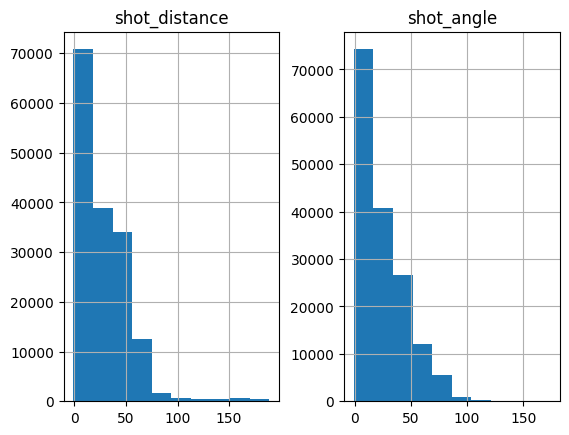

Text(0.5, 0.98, 'Histograms of Features')

<Figure size 640x480 with 0 Axes>

In [40]:
#Histograms for numerical features

predictors[pred_numeric].hist()
plt.show()
plt.suptitle("Histograms of Features")


#visualization of categorical features (value.counts() took large time)


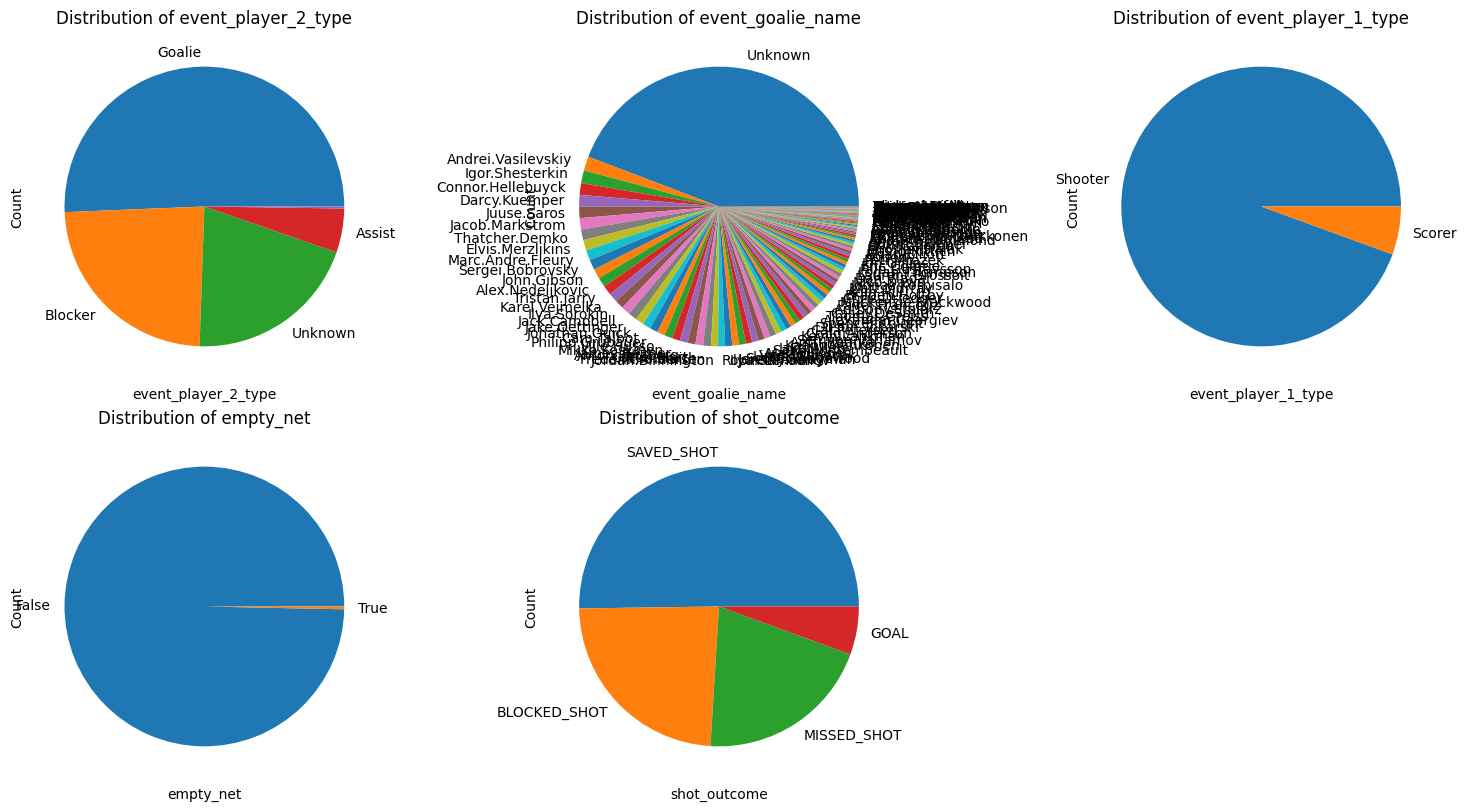

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [41]:
# Loop through each categorical feature and plot its distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 2 * 4), constrained_layout=True)

axes = axes.flatten()
for i, feature in enumerate( pred_categoric): 
    plt.figure(figsize=(12, 4))
    predictors[feature].value_counts().plot(kind='pie', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

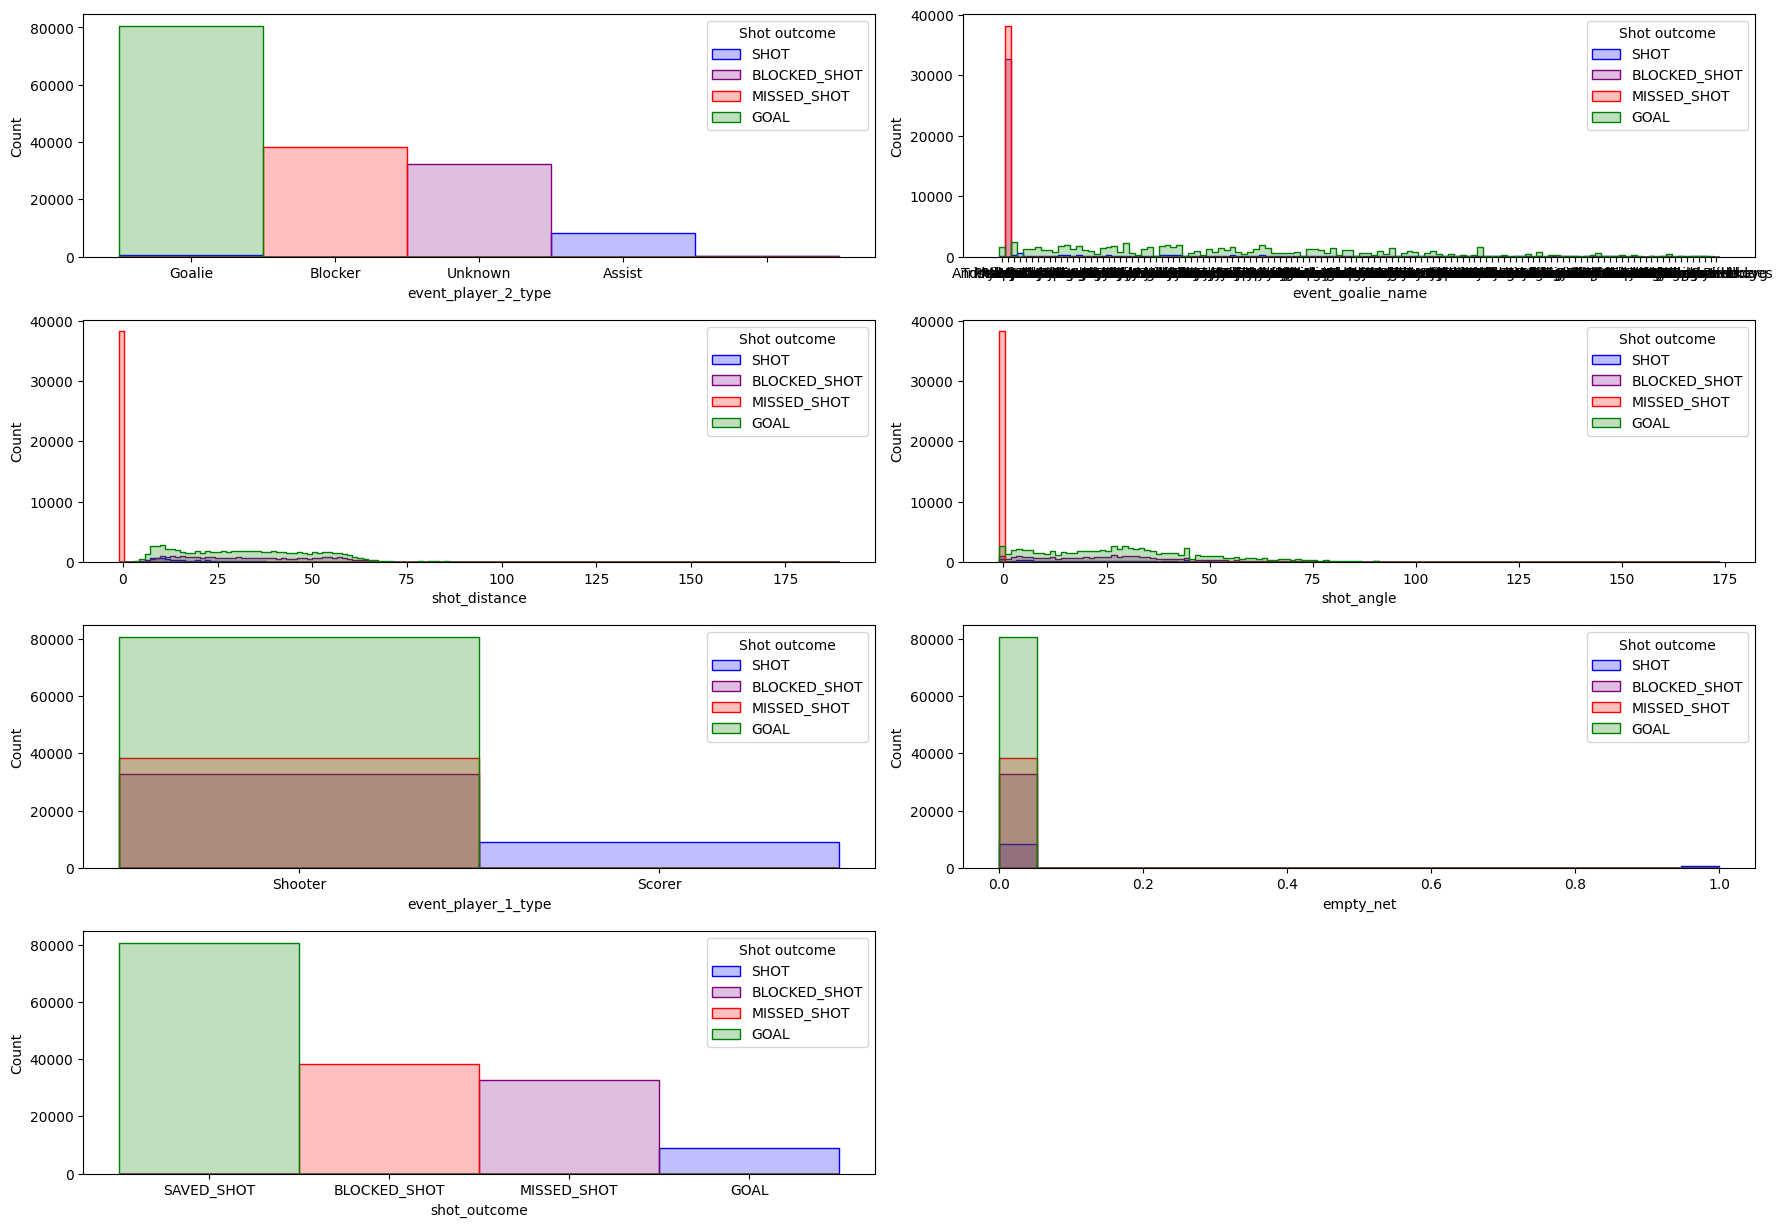

In [42]:

plt.figure(figsize=(18, 15))
for idx, feature in enumerate(predictors.columns):
    plt.subplot(5, 2, idx + 1)
    sns.histplot(data=predictors, x=feature, hue='shot_outcome', element='step', kde=False, palette=['green', 'red','purple','blue'])
    plt.legend(title='Shot outcome', loc='upper right', labels=['SHOT', 'BLOCKED_SHOT','MISSED_SHOT','GOAL'])

plt.tight_layout()
plt.show()


## Label Encoding & Normalization

In [43]:
predictors.head()

,event_player_2_type,event_goalie_name,shot_distance,shot_angle,event_player_1_type,empty_net,shot_outcome
0,Goalie,Tristan.Jarry,42.5,48.8,Shooter,False,SAVED_SHOT
1,Blocker,Unknown,-1.0,-1.0,Shooter,False,BLOCKED_SHOT
2,Goalie,Andrei.Vasilevskiy,30.6,38.4,Shooter,False,SAVED_SHOT
3,Goalie,Tristan.Jarry,100.7,15.6,Shooter,False,SAVED_SHOT
4,Goalie,Andrei.Vasilevskiy,29.3,7.9,Shooter,False,SAVED_SHOT


In [44]:
_encoder_ = LabelEncoder()
for i in pred_categoric:
    predictors.loc[:, i] = _encoder_.fit_transform(predictors[[i]]).astype('int32')
predictors.head()

c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site

,event_player_2_type,event_goalie_name,shot_distance,shot_angle,event_player_1_type,empty_net,shot_outcome
0,3,113,42.5,48.8,1,0,3
1,2,116,-1.0,-1.0,1,0,0
2,3,8,30.6,38.4,1,0,3
3,3,113,100.7,15.6,1,0,3
4,3,8,29.3,7.9,1,0,3


### Outlier Detection and Handling 

Iqr method is can be used both normal distrubted and not normal distrubuted data , due to this ı will us ıqr to detect outliers

In [45]:
def outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


NameError: name 'df_important' is not defined

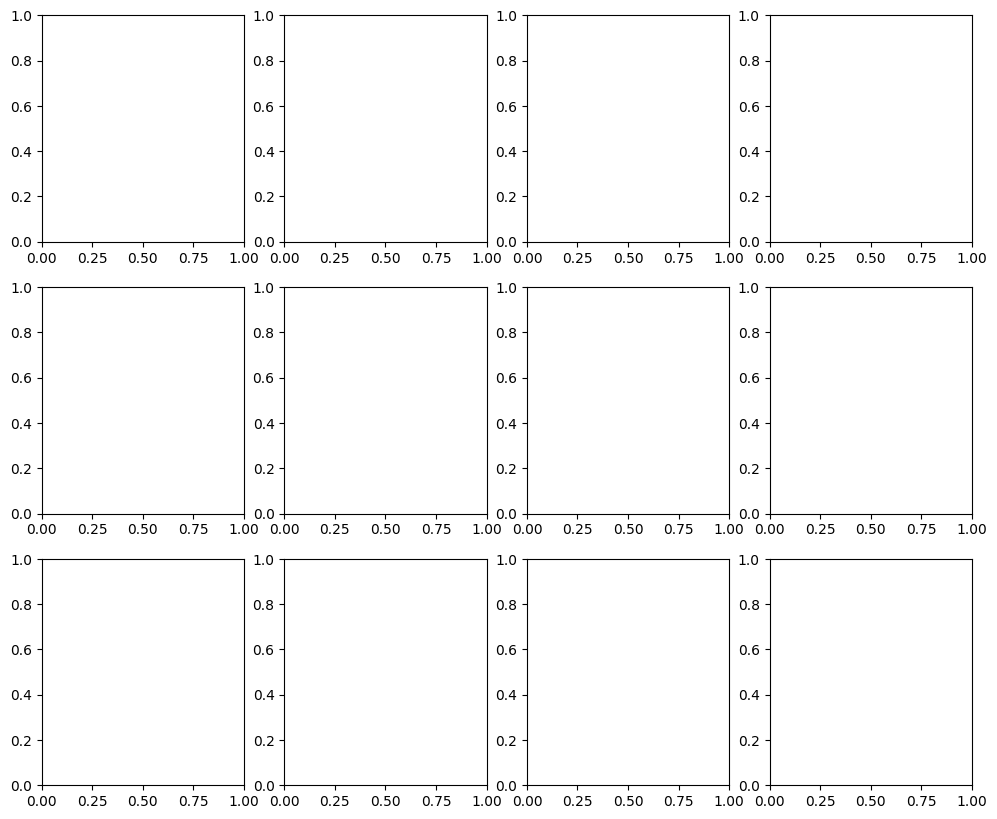

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))  
axes = axes.flatten()

# Counter for the axes
ax_index = 0


for column in df_important.drop('shot_outcome',axis=1).columns:
    lower_bound, upper_bound = outliers(df_important[column])

    # Plot boxplot for the original dataframe (data)
    sns.boxplot(y=df_important[column], ax=axes[ax_index])
    axes[ax_index].set_title(f'Before outlier handling for {column}')
    axes[ax_index].tick_params(axis='x', rotation=45)

    # Apply clipping
    df_important.loc[df_important[column] < lower_bound, column] = lower_bound
    df_important.loc[df_important[column] > upper_bound, column] = upper_bound

    # Plot boxplot for the modified dataframe 
    sns.boxplot(y=df_important[column], ax=axes[ax_index+1])
    axes[ax_index+1].set_title(f'After outlier handling for {column}')
    axes[ax_index+1].tick_params(axis='x', rotation=45)

    # Increment the counter
    ax_index += 2

    # Break if we reach the end of the axes array
    if ax_index >= len(axes):
        break

plt.tight_layout()
plt.show()


### Normalization 

In [ ]:
# Sample data (replace with your dataset)
X = df_encoded.drop(columns=['shot_outcome'])  # Features
y = df_encoded['shot_outcome']                # Target

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_important)

data_normalized = pd.DataFrame(X, columns=df_important.drop(columns=['shot_outcome']).columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

data_normalized.head()

,event_player_2_type,event_goalie_name,shot_distance,shot_angle,event_player_1_type,empty_net
0,2,113,42.5,48.8,1,2
1,1,120,NaN,NaN,1,2
2,2,8,30.6,38.4,1,2
3,2,113,100.7,15.6,1,2
4,2,8,29.3,7.9,1,2


## Model Building

In [ ]:
#plot learning curve to be sure models are not overfitted or underfitted.
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




In [ ]:
xgb_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05]}
xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)

NameError: name 'XGBClassifier' is not defined

In [ ]:
xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


KeyboardInterrupt: 

In [ ]:
xgb_model = XGBClassifier(**xgb_cv_model.best_params_)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
plot_learning_curve(xgb_model,"XGBoost Learning Curve",X_train,y_train,ylim=(0.7, 1.01))

plt.show()

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score



In [ ]:
catb_params = {
    'iterations': [200,500],
    'learning_rate': [0.01,0.05, 0.1],
    'depth': [3,5,8] }

In [ ]:
catb = CatBoostClassifier()
catb_cv_model = RandomizedSearchCV(catb, catb_params, cv=10, n_jobs = -1, verbose = 2)
catb_cv_model.fit(X_train, y_train)
catb_cv_model.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0:	learn: 1.2411140	total: 68.6ms	remaining: 34.2s
1:	learn: 1.1227964	total: 139ms	remaining: 34.5s
2:	learn: 1.0230835	total: 214ms	remaining: 35.4s
3:	learn: 0.9366045	total: 286ms	remaining: 35.4s
4:	learn: 0.8612305	total: 331ms	remaining: 32.7s
5:	learn: 0.7949211	total: 406ms	remaining: 33.4s
6:	learn: 0.7360799	total: 465ms	remaining: 32.7s
7:	learn: 0.6830939	total: 499ms	remaining: 30.7s
8:	learn: 0.6353639	total: 544ms	remaining: 29.7s
9:	learn: 0.5922268	total: 613ms	remaining: 30.1s
10:	learn: 0.5529695	total: 641ms	remaining: 28.5s
11:	learn: 0.5170914	total: 708ms	remaining: 28.8s
12:	learn: 0.4841845	total: 775ms	remaining: 29s
13:	learn: 0.4540121	total: 843ms	remaining: 29.3s
14:	learn: 0.4261706	total: 912ms	remaining: 29.5s
15:	learn: 0.4002827	total: 954ms	remaining: 28.9s
16:	learn: 0.3763124	total: 996ms	remaining: 28.3s
17:	learn: 0.3541945	total: 1.07s	remaining: 28.6s
18:	learn: 0.3335538	total: 1.

{'learning_rate': 0.05, 'iterations': 500, 'depth': 8}

In [ ]:
catb = CatBoostClassifier(**catb_cv_model.best_params_)

catboost = catb.fit(X_train, y_train)
y_pred_cboost = catboost.predict(X_test)
accuracy_score(y_test, y_pred_cboost)


0:	learn: 1.2411140	total: 63.5ms	remaining: 31.7s
1:	learn: 1.1227964	total: 124ms	remaining: 30.9s
2:	learn: 1.0230835	total: 184ms	remaining: 30.5s
3:	learn: 0.9366045	total: 240ms	remaining: 29.8s
4:	learn: 0.8612305	total: 278ms	remaining: 27.5s
5:	learn: 0.7949211	total: 345ms	remaining: 28.4s
6:	learn: 0.7360799	total: 395ms	remaining: 27.8s
7:	learn: 0.6830939	total: 429ms	remaining: 26.4s
8:	learn: 0.6353639	total: 469ms	remaining: 25.6s
9:	learn: 0.5922268	total: 531ms	remaining: 26s
10:	learn: 0.5529695	total: 557ms	remaining: 24.8s
11:	learn: 0.5170914	total: 619ms	remaining: 25.2s
12:	learn: 0.4841845	total: 684ms	remaining: 25.6s
13:	learn: 0.4540121	total: 752ms	remaining: 26.1s
14:	learn: 0.4261706	total: 824ms	remaining: 26.6s
15:	learn: 0.4002827	total: 866ms	remaining: 26.2s
16:	learn: 0.3763124	total: 908ms	remaining: 25.8s
17:	learn: 0.3541945	total: 978ms	remaining: 26.2s
18:	learn: 0.3335538	total: 1.05s	remaining: 26.6s
19:	learn: 0.3143030	total: 1.11s	remainin

1.0

0:	learn: 1.2484726	total: 16.9ms	remaining: 8.44s
1:	learn: 1.1314856	total: 33.2ms	remaining: 8.26s
2:	learn: 1.0314436	total: 41.5ms	remaining: 6.88s
3:	learn: 0.9459591	total: 57.5ms	remaining: 7.13s
4:	learn: 0.8727134	total: 75.6ms	remaining: 7.48s
5:	learn: 0.8063696	total: 91.8ms	remaining: 7.56s
6:	learn: 0.7473183	total: 100ms	remaining: 7.06s
7:	learn: 0.6935135	total: 103ms	remaining: 6.33s
8:	learn: 0.6477467	total: 119ms	remaining: 6.49s
9:	learn: 0.6064918	total: 135ms	remaining: 6.64s
10:	learn: 0.5669910	total: 144ms	remaining: 6.39s
11:	learn: 0.5319163	total: 159ms	remaining: 6.48s
12:	learn: 0.4986367	total: 176ms	remaining: 6.61s
13:	learn: 0.4686197	total: 193ms	remaining: 6.7s
14:	learn: 0.4411548	total: 210ms	remaining: 6.78s
15:	learn: 0.4151568	total: 227ms	remaining: 6.88s
16:	learn: 0.3913190	total: 245ms	remaining: 6.95s
17:	learn: 0.3686863	total: 248ms	remaining: 6.64s
18:	learn: 0.3479276	total: 266ms	remaining: 6.73s
19:	learn: 0.3277555	total: 269ms	re

<module 'matplotlib.pyplot' from 'c:\\Users\\NURŞAH SATILMIŞ\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

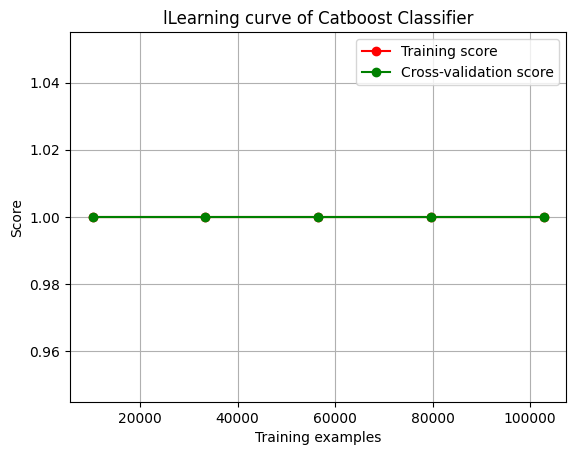

In [ ]:
plot_learning_curve(catboost,"lLearning curve of Catboost Classifier",X_train,y_train)

QUESTİONS :

Feature engineering . How can I decide which features should be selected? korolasyon analizi ile karar ver  
Should I decide select features first or select model first ? feature selection 
I will experiment on  Linear regression or knn 
Ensemble models like DT , Boosting models
SVM
and neural network (kerasClassifier)

First find best model then experiment